# VAE
Variational autoencoder [1] models inherit autoencoder architecture, but  use variational approach for latent representation learning. In this homework, we will implement VAE and quantitatively measure the quality of the generated samples via Inception score [2,3].

[1] Auto-Encoding Variational Bayes, Diederik P Kingma, Max Welling 2013
https://arxiv.org/abs/1312.6114

[2] Improved techniques for training gans, Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Rad- ford, A., and Chen, X. 2016
In Advances in Neural Information Processing Systems 

[3] A note on inception score, Shane Barratt, Rishi Sharma 2018
https://arxiv.org/abs/1801.01973


# PART I. Train a good VAE model

## Setup

In [0]:
import tensorflow as tf
if tf.__version__ < '2.0.0':         
    tf.enable_eager_execution()      
tf.executing_eagerly()               

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    # images reshape to (batch_size, D)
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

## Dataset
We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [0]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

11493376/11490434 [==============================] - 0s 0us/step


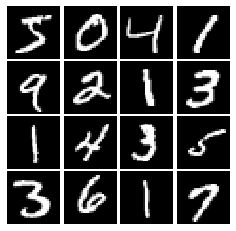

In [4]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

In [0]:
X_DIM = mnist.X[0].size
num_samples = 100000
num_to_show = 100

# Hyperparamters. Your job to find these.
# TODO:
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
num_epochs = 50
batch_size = 50
Z_DIM = 5
learning_rate = 2e-4
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## Encoder
Our first step is to build a variational encoder network $q_\phi(z \mid x)$. 

**Hint:** You should use the layers in `tf.keras.layers` to build the model. Use four FC layers. All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.keras.layers` functions. 

The output of the encoder should thus have shape `[batch_size, 2*z_dim]`, and contain real numbers corresponding to the mean $\mu(x_i)$ and diagonal log variance $\log \sigma(x_i)^2$ of each of the `batch_size` input images. Note, we want to make it return log of the variance for numerical stability.

**WARNING:** Do not apply any non-linearity to the last activation.

In [0]:
def q_phi(z_dim=Z_DIM, x_dim=X_DIM):
  model = tf.keras.models.Sequential([
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****                                  
    tf.keras.layers.Dense(392, activation="relu", use_bias=True, input_shape=(x_dim,)),
    tf.keras.layers.Dense(196, activation="relu", use_bias=True),
    tf.keras.layers.Dense(128, activation="tanh", use_bias=True),
    tf.keras.layers.Dense(2 * z_dim,  use_bias=True)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  ])
  return model

In [0]:
# TODO: implement reparameterization trick
def sample_z(mu, log_var):
  # Your code here for the reparameterization trick.
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  samples = None
  #print(mu.shape)
  z = tf.random.normal(tf.shape(mu))
  s = tf.math.exp(0.5 * log_var)
  samples = mu + s * z
  return samples
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## Decoder
Now to build a decoder network $p_\theta(x \mid z)$. You should use the layers in `tf.keras.layers` to construct the model. Use four FC layers. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

In this exercise, we will use Bernoulli MLP decoder where $p_\theta(x \mid z)$ is modeled with multivariate Bernoulli distribution, in contrast to the Gaussian distribution we discussed in the lecture, as following (see Appendix C.1 in the original paper for more details).

$\log p(x \mid z) = \sum_{i=1} x_i \log z_i + (1-x_i) \log (1-z_i)$

Note, the output of the decoder should have shape `[batch_size, x_dim]` and should output the unnormalized logits of $x_i$.

**WARNING:** Do not apply any non-linearity to the last activation.

In [0]:
def p_theta(z_dim=Z_DIM, x_dim=X_DIM):
  model = tf.keras.models.Sequential([
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    tf.keras.layers.Dense(128, activation="tanh", use_bias=True, input_shape=(z_dim,)),
    tf.keras.layers.Dense(196, activation="relu", use_bias=True),
    tf.keras.layers.Dense(392, activation="relu", use_bias=True),
    tf.keras.layers.Dense(x_dim, use_bias=True)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  ])
  return model                             

## Loss definition
Compute the VAE loss. 
1. For the reconstruction loss, you might find `tf.nn.sigmoid_cross_entropy_with_logits` or `tf.keras.losses.BinaryCrossentropy` useful.
2. For the kl loss, we discussed the closed form kl divergence between two gaussians in the lecture.

In [0]:
def vae_loss(x, x_logit, z_mu, z_logvar):
  recon_loss = None
  kl_loss = None # negative value

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  #print(x, x_logit)
  #bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
  recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, x_logit), axis=1)
  #entropy = bce(x, x_logit)
  #recon_loss = tf.reduce_sum(entropy)
  #print(entropy.shape, recon_loss.shape)
  temp =  1 + z_logvar - tf.square(z_mu) - tf.math.exp(z_logvar)
  kl_loss = -0.5 * (tf.reduce_sum(temp, axis = 1))
  #print(kl_loss, z_mu, z_logvar)
  #print(recon_loss, kl_loss)
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  #print(kl_loss)
  vae_loss = tf.reduce_mean(recon_loss + kl_loss)
  return vae_loss, tf.reduce_mean(recon_loss)

## Optimizing our loss


In [0]:
Q = q_phi()
P = p_theta()
solver = tf.keras.optimizers.Adam(learning_rate)      
mnist = MNIST(batch_size=batch_size, shuffle=True)

Visualize generated samples before training

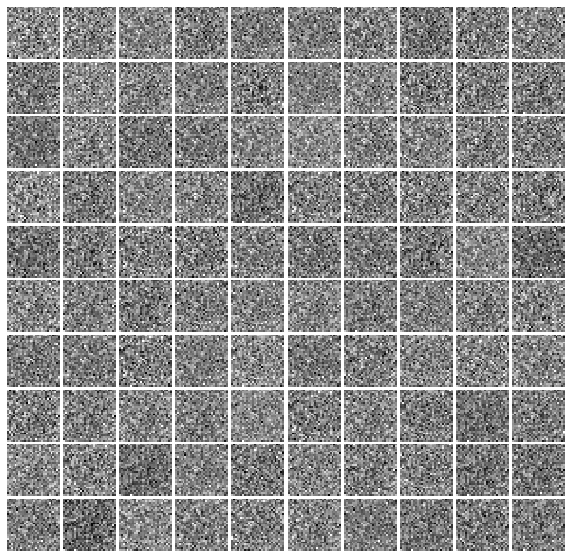

In [29]:
z_gen = tf.random.normal(shape=[num_to_show, Z_DIM])
x_gen = P(z_gen)
imgs_numpy = tf.nn.sigmoid(x_gen).numpy()
show_images(imgs_numpy)
plt.show()

## Training a VAE!
If everything works, your batch average reconstruction loss should drop below 95.

In [62]:
iter_count = 0
show_every = 400
for epoch in range(num_epochs):
  for (x_i, _) in mnist:
    with tf.GradientTape() as tape:
      z_concat = Q(preprocess_img(x_i))
      z_mu, z_logvar = tf.split(z_concat, num_or_size_splits=2, axis=1)
      z_i = sample_z(z_mu, z_logvar)
      
      x_logit = P(z_i)
      loss, recon_loss = vae_loss(x_i, x_logit, z_mu, z_logvar)
      
      grads = tape.gradient(loss, 
                [Q.trainable_variables, P.trainable_variables])

      solver.apply_gradients(zip([*grads[0],*grads[1]],              
                [*Q.trainable_variables, *P.trainable_variables]))   

      if (iter_count % show_every == 0):
        print('Epoch: {}, Iter: {}, Loss: {:.4}, Recon: {:.4}'.format(
            epoch, iter_count, loss, recon_loss))
        #imgs_numpy = tf.nn.sigmoid(x_logit).numpy()
        #show_images(imgs_numpy[0:16])
        #plt.show()
      iter_count += 1

Epoch: 0, Iter: 0, Loss: 106.2, Recon: 93.65
Epoch: 0, Iter: 400, Loss: 114.8, Recon: 101.7
Epoch: 0, Iter: 800, Loss: 114.1, Recon: 101.5
Epoch: 1, Iter: 1200, Loss: 105.8, Recon: 93.32
Epoch: 1, Iter: 1600, Loss: 114.8, Recon: 101.7
Epoch: 1, Iter: 2000, Loss: 112.9, Recon: 100.4
Epoch: 2, Iter: 2400, Loss: 106.0, Recon: 93.48
Epoch: 2, Iter: 2800, Loss: 113.7, Recon: 100.5
Epoch: 2, Iter: 3200, Loss: 114.0, Recon: 101.4
Epoch: 3, Iter: 3600, Loss: 105.6, Recon: 93.13
Epoch: 3, Iter: 4000, Loss: 114.0, Recon: 100.8
Epoch: 3, Iter: 4400, Loss: 114.7, Recon: 102.0
Epoch: 4, Iter: 4800, Loss: 105.7, Recon: 93.15
Epoch: 4, Iter: 5200, Loss: 113.4, Recon: 100.2
Epoch: 4, Iter: 5600, Loss: 113.5, Recon: 100.7
Epoch: 5, Iter: 6000, Loss: 104.9, Recon: 92.34
Epoch: 5, Iter: 6400, Loss: 113.8, Recon: 100.5
Epoch: 5, Iter: 6800, Loss: 115.0, Recon: 102.4
Epoch: 6, Iter: 7200, Loss: 105.2, Recon: 92.52
Epoch: 6, Iter: 7600, Loss: 114.4, Recon: 101.1
Epoch: 6, Iter: 8000, Loss: 113.9, Recon: 101

Visualize generated samples after training

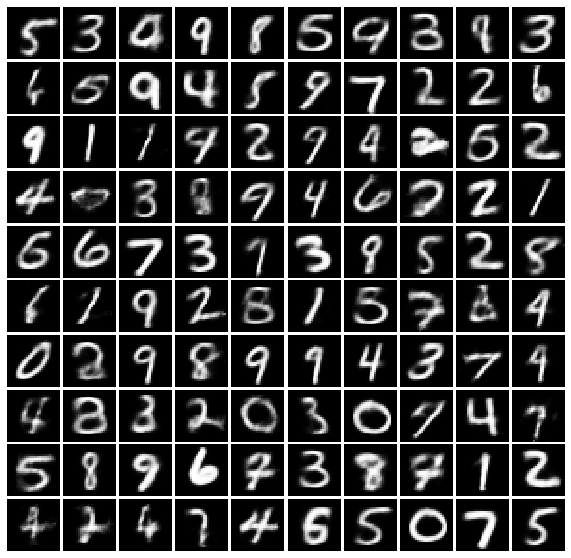

In [63]:
z_gen = tf.random.normal(shape=[num_to_show, Z_DIM])
x_gen = P(z_gen)
imgs_numpy = tf.nn.sigmoid(x_gen).numpy()
show_images(imgs_numpy)
plt.show()

# PART II. Compute the inception score for your trained VAE model
In this part, we will quantitavely measure how good your VAE model is.

### Train a classifier
We first need to train a classifier. 

In [64]:
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(784,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 

###Verify the trained classifier on the generated samples
Generate samples and visually inspect if the predicted labels on the samples match the actual digits in generated images.

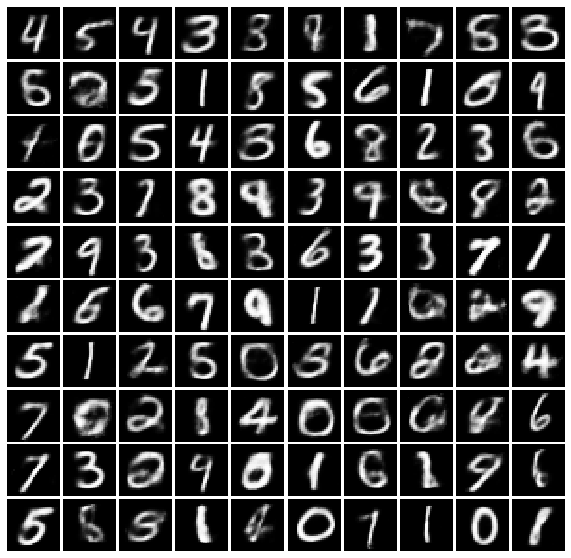

In [65]:
z_gen = tf.random.normal(shape=[num_samples, Z_DIM])
x_gen = P(z_gen)
imgs_numpy = tf.nn.sigmoid(x_gen[:num_to_show]).numpy()
show_images(imgs_numpy)
plt.show()

In [66]:
np.argmax(model.predict(tf.nn.sigmoid(x_gen[:20])), axis=-1)

array([4, 5, 4, 3, 3, 8, 1, 7, 5, 3, 5, 0, 5, 1, 5, 5, 6, 1, 0, 9])

### Implement the inception score
Implement Equation 1 in the reference [3]. Replace expectation in the equation with empirical average of `num_samples` samples. Don't forget the exponentiation at the end. You should get Inception score of at least 9.0.

In [67]:
kld_obj = tf.keras.losses.KLDivergence()
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

score = None
image = tf.nn.sigmoid(x_gen)
predicted_y = model.predict(image) #p(y|x)
true_y  =  np.ones ((num_samples, 1)) * np.mean(predicted_y, axis = 0)

score = np.exp(kld_obj(predicted_y, true_y))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print('Inception score: {:.4}'.format(score))

Inception score: 9.231


### Plot the histogram of predicted labels
Let's additionally inspect the class diversity of the generated samples.

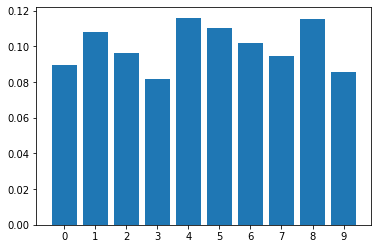

In [68]:
plt.hist(np.argmax(model.predict(tf.nn.sigmoid(x_gen)), axis=-1),
         bins=np.arange(11)-0.5, rwidth=0.8, density=True)
plt.xticks(range(10))
plt.show()